AI and ML

Fruit Classification

Group

Siyangla Bhote
Rama Basnet


In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import VGG16


#load dataset
data_dir = '/content/drive/MyDrive/Fruit Classification/Train'

Data Understanding, Analysis, Visualizaztion and Cleaning

In [52]:
# Dataset exploration
train_dir = os.path.join(data_dir, '/content/drive/MyDrive/Fruit Classification/Train')
test_dir = os.path.join(data_dir, '/content/drive/MyDrive/Fruit Classification/Test')
class_names = os.listdir(train_dir)

print("Classes:", class_names)

Classes: ['Peach', 'Banana', 'Cherry', 'Mango', 'Grape']


In [53]:
# Count total images
total_images = 0
class_counts = {}
for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    count = len(os.listdir(cls_path))
    class_counts[cls] = count
    total_images += count

print("Total images:", total_images)

Total images: 5573


In [122]:
def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))])
    return count

train_path = '/content/drive/MyDrive/Fruit Classification/Train'
test_path = '/content/drive/MyDrive/Fruit Classification/Test'

train_count = count_images_in_folder(train_path)
test_count = count_images_in_folder(test_path)

print(f"Training Set: {train_count}")
print(f"Test Set: {test_count}")

Training Set: 5573
Test Set: 5


In [123]:
len(os.listdir('/content/drive/MyDrive/Fruit Classification/Train'))


5

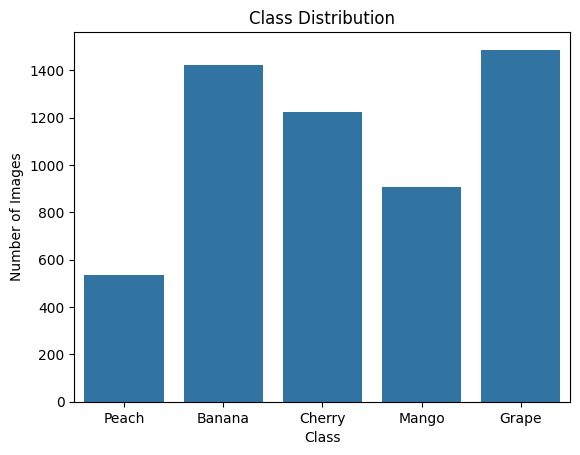

In [54]:
# Plot class distribution
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [129]:
def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.lower().endswith(('png', 'jpg', 'jpeg'))])
    return count

train_path = '/content/drive/MyDrive/Fruit Classification/Train'
test_path = '/content/drive/MyDrive/Fruit Classification/Test'

train_count = count_images_in_folder(train_path)
test_count = count_images_in_folder(test_path)

print(f"Training Set: {train_count}")
print(f"Test Set: {test_count}")

Training Set: 5573
Test Set: 5


Preprocessing AND Augmentation

In [55]:
# Resize images to 100x100
IMG_SIZE = 100

# Data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 4461 images belonging to 5 classes.
Found 1112 images belonging to 5 classes.


In [56]:
#Dataset structure checker
train_dir = '/content/drive/MyDrive/Fruit Classification/Train'

print(f"Inspecting directory: {train_dir}")
has_issues = False

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Found class directory: {class_name} with {len(os.listdir(class_path))} images")
    else:
        print(f"File found directly in Train folder (should not be here): {class_name}")
        has_issues = True

if not has_issues:
    print("\n Structure looks good! No suspicious files.")
else:
    print("\n Please manually move any misplaced files into their appropriate class folders.")

Inspecting directory: /content/drive/MyDrive/Fruit Classification/Train
Found class directory: Banana with 1422 images
Found class directory: Cherry with 1222 images
Found class directory: Grape with 1487 images
Found class directory: Mango with 908 images
Found class directory: Peach with 534 images

 Structure looks good! No suspicious files.


Visualizing Augmented

In [73]:
def clean_dataset(folder_path):
    deleted = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Validate image
            except:
                print(f" Corrupted: {file_path} — Deleting...")
                os.remove(file_path)
                deleted += 1
    print(f"\n Cleanup complete. Deleted {deleted} bad image(s).\n")

# Clean both Train and Test datasets
clean_dataset('/content/drive/MyDrive/Fruit Classification/Train')
clean_dataset('/content/drive/MyDrive/Fruit Classification/Test')


 Cleanup complete. Deleted 0 bad image(s).


 Cleanup complete. Deleted 0 bad image(s).



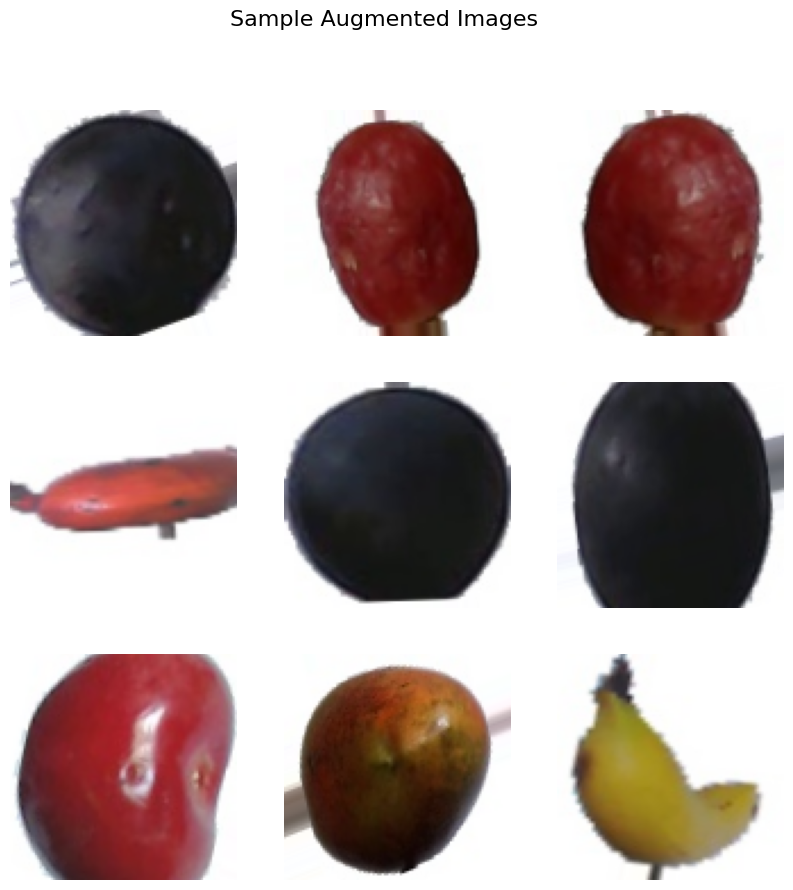

In [76]:
# Get one batch from generator
images, labels = next(train_generator)

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.show()


##Baseline CNN Model

In [77]:
baseline_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

baseline_model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,277 (6.65 MB)

 Trainable params: 1,742,277 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history_baseline = baseline_model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)


Epoch 1/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 116s 831ms/step - accuracy: 0.9754 - loss: 0.0808 - val_accuracy: 0.9955 - val_loss: 0.0109
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 113s 810ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.8822 - val_loss: 0.2905
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 134s 755ms/step - accuracy: 0.9895 - loss: 0.0328 - val_accuracy: 0.9892 - val_loss: 0.0318


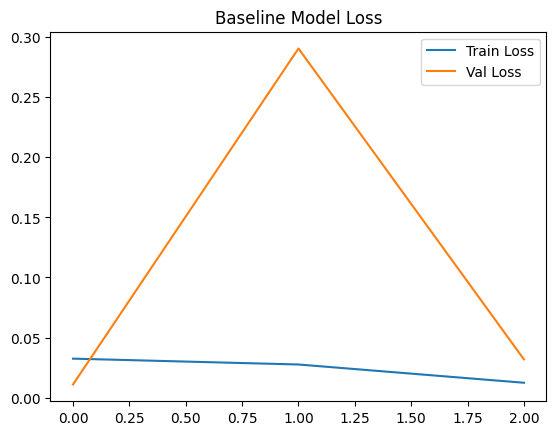

In [78]:
#plot training vs validation loss
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Baseline Model Loss")
plt.show()


##Deeper CNN with Regularization

In [81]:
class_names = os.listdir(train_dir)
print("Classes:", class_names)

Classes: ['Peach', 'Banana', 'Cherry', 'Mango', 'Grape']


In [84]:
# Define the number of classes based on the directories in the training folder
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

deeper_model = models.Sequential([
    # Change input_shape to match the target_size of the generators (100, 100)
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(100, 100, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),
    layers.Dense(128, activation='relu'),
    Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

deeper_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

deeper_model.summary()

Number of classes: 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,470,789 (5.61 MB)

 Trainable params: 1,470,789 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history_deep = deeper_model.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 122s 850ms/step - accuracy: 0.5979 - loss: 1.1481 - val_accuracy: 0.9550 - val_loss: 0.2291
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 117s 835ms/step - accuracy: 0.9790 - loss: 0.2042 - val_accuracy: 0.9928 - val_loss: 0.1284
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 117s 836ms/step - accuracy: 0.9927 - loss: 0.1244 - val_accuracy: 0.9964 - val_loss: 0.0974


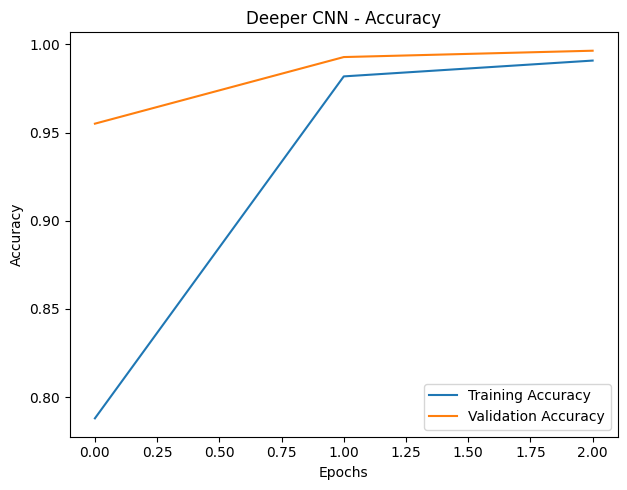

In [87]:
# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_deep.history['accuracy'], label='Training Accuracy')
plt.plot(history_deep.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper CNN - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

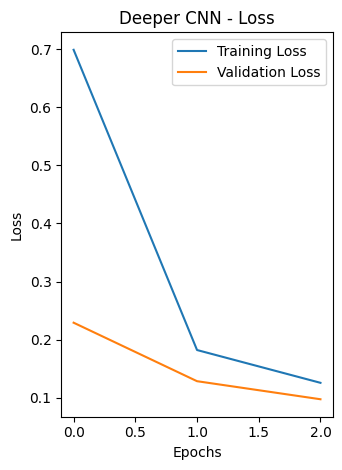

In [88]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_deep.history['loss'], label='Training Loss')
plt.plot(history_deep.history['val_loss'], label='Validation Loss')
plt.title('Deeper CNN - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##Optimizer  Comparision (SGD vs Adam)

In [89]:
deeper_model_sgd = tf.keras.models.clone_model(deeper_model)
deeper_model_sgd.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

history_sgd = deeper_model_sgd.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)


Epoch 1/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 123s 854ms/step - accuracy: 0.4722 - loss: 1.5072 - val_accuracy: 0.7509 - val_loss: 0.9815
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 127s 904ms/step - accuracy: 0.8426 - loss: 0.7502 - val_accuracy: 0.9676 - val_loss: 0.4071
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 118s 846ms/step - accuracy: 0.9469 - loss: 0.4288 - val_accuracy: 0.9991 - val_loss: 0.2946


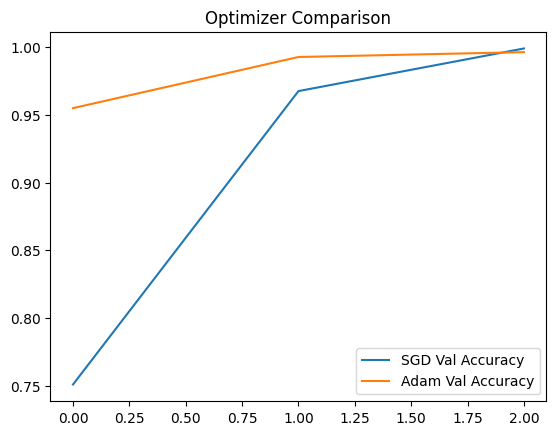

In [90]:
plt.plot(history_sgd.history['val_accuracy'], label='SGD Val Accuracy')
plt.plot(history_deep.history['val_accuracy'], label='Adam Val Accuracy')
plt.legend()
plt.title("Optimizer Comparison")
plt.show()


##Transfer Learning (Feature Extraction) using VGG16

In [94]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze convolutional base

model_feature_extract = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_feature_extract.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

model_feature_extract.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,895,877 (60.64 MB)

 Trainable params: 1,181,189 (4.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [95]:
history_feat = model_feature_extract.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.7793 - loss: 0.6190 - val_accuracy: 0.9604 - val_loss: 0.1171
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 652s 5s/step - accuracy: 0.9850 - loss: 0.0658 - val_accuracy: 0.9730 - val_loss: 0.0722
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 630s 5s/step - accuracy: 0.9935 - loss: 0.0305 - val_accuracy: 0.9973 - val_loss: 0.0216


##Transfer Learning (Fine-Tuning)

In [98]:
base_model.trainable = True

# Freeze first few layers
for layer in base_model.layers[:10]:
    layer.trainable = False

model_finetune = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_finetune.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])




In [100]:
history_finetune = model_finetune.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 1137s 8s/step - accuracy: 0.6499 - loss: 0.8938 - val_accuracy: 0.9982 - val_loss: 0.0272
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 1129s 8s/step - accuracy: 0.9981 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 1129s 8s/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 4.9168e-04


Final Evalution on Test Set

In [117]:
#Test image path set
test_dir = '/content/drive/MyDrive/Fruit Classification/Test'

#Image path and dummy label with dataframe
test_filenames = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
test_df = pd.DataFrame({
    'filename': test_filenames,
    'class': ['unknown'] * len(test_filenames)  # dummy label
})

#ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,  # No true labels available
    # Change target_size to match the model's expected input size
    target_size=(100, 100),
    class_mode=None,
    shuffle=False,
    batch_size=32
)

# Prediction
y_pred = model_finetune.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


# Get the class labels from the training generator for mapping predictions
class_labels = list(train_generator.class_indices.keys())

# Show predicted class for each image
for fname, pred_class in zip(test_filenames, y_pred_classes):
    print(f"{fname} → Predicted: {class_labels[pred_class]}")

Found 5 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
14_100.jpg → Predicted: Grape
26_100.jpg → Predicted: Peach
11_100.jpg → Predicted: Mango
1_100(2).jpg → Predicted: Banana
5_100.jpg → Predicted: Cherry
